# Spatial Transform Demo 

In [6]:
# packages that will be used 
import json
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns 
import matplotlib.pyplot as plt
from Functions.SpatialTransform import SpatialTransformer # this is the class that will be used to transform the data

 
# Opening JSON file
with open('NonLinSimDataSet17.json') as json_file:
    data = json.load(json_file)

#convert datasets into dataframe 
trainData = pd.DataFrame(data['trainData'])
testData = pd.DataFrame(data['testData'])

#convert the location into arrays
trainLocs = np.array(data['trainLocs'])
testLocs = np.array(data['testLocs'])

#nugget 
nugget = np.array(data['nugget'])[0]

#range 
range_param = np.array(data['range'])[0]
 

## Spatial Dataset 

This is the scatterplot that displays the spatial pattern of the simulation dataset. Our goal is to utilize this spatial information in our predictions.

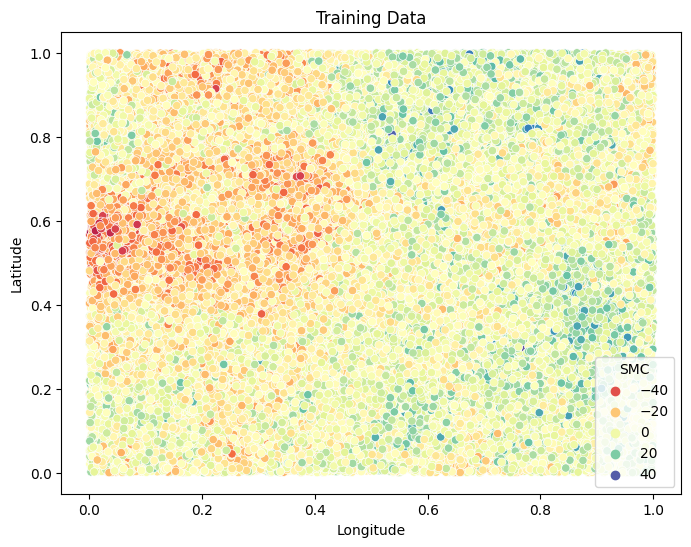

In [7]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=trainData, x=trainLocs[:,0], y=trainLocs[:,1], hue='y', palette='Spectral')
plt.title('Training Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(False)
plt.legend(title='SMC')
plt.show()

## Spatial Transformer

SpatialTransformer is a class object that has attributes that can be used to transform your data. 

In [8]:
transformer = SpatialTransformer()

IndData = transformer.transform_to_ind("y", 
                             trainData=trainData, 
                             testData=testData, 
                             testLocs=testLocs, 
                             trainLocs=trainLocs, 
                             smoothness = 0.5, 
                             range_param = range_param, 
                             nugget = nugget, 
                             M=30, 
                             ncores = 1)

In [9]:
#Splitting the data into the independent and dependent variables from IndData['trainData]
X_train_spatial = IndData['trainData'].drop(columns=['y'])
y_train_spatial = IndData['trainData']['y']


#Random Foreset 
spatial_rf_spatial = RandomForestRegressor(random_state = 200)
rf_spatial = RandomForestRegressor(random_state = 200)

param_grid = {
    'max_features': [6,7,8,9],
    'min_samples_leaf': [5,10,15,20]
}

# Instantiate the grid search model
spatial_grid_search = GridSearchCV(estimator = spatial_rf_spatial, param_grid = param_grid, 
                          cv = 5, n_jobs = 5)

grid_search = GridSearchCV(estimator = rf_spatial, param_grid = param_grid, 
                          cv = 5, n_jobs = 5)


spatial_grid_search.fit(X_train_spatial, y_train_spatial)

grid_search.fit(trainData.drop(columns=['y']), trainData['y'])

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=200), n_jobs=5,
             param_grid={'max_features': [6, 7, 8, 9],
                         'min_samples_leaf': [5, 10, 15, 20]})

## Prediction Error Comparison

As shown below, our spatial predictions have a lower rmse than the normal random forest predictions. 

In [10]:
#Random Forest Model hyperparameters 
rf_spatial_fit = RandomForestRegressor(**spatial_grid_search.best_params_).fit(X_train_spatial,y_train_spatial)

rf_fit = RandomForestRegressor(**grid_search.best_params_).fit(trainData.drop(columns=['y']), trainData['y'])

#Predicting the test data
X_test = IndData['testData']

y_pred_spatial = rf_spatial_fit.predict(X_test)

y_pred = rf_fit.predict(testData.drop(columns=['y']))

#convert the prediceted values back to spatial
y_pred_spatial = transformer.back_transform_to_spatial(y_pred_spatial,IndData)

import math
spatial_MSE = np.square(np.subtract(testData['y'],y_pred_spatial)).mean() 
MSE = np.square(np.subtract(testData['y'],y_pred)).mean()

 
spatial_RMSE = math.sqrt(spatial_MSE)
RMSE = math.sqrt(MSE)


print("Root Mean Square Error:\n")
print("Spatial RMSE: ", spatial_RMSE)
print("Non-spatial RMSE: ", RMSE)


Root Mean Square Error:

Spatial RMSE:  6.607211469968269
Non-spatial RMSE:  10.147692206239833


## Spatial Predictions 

Our spatial random forest captures the spatial patterns of the true values over the regular random forest.

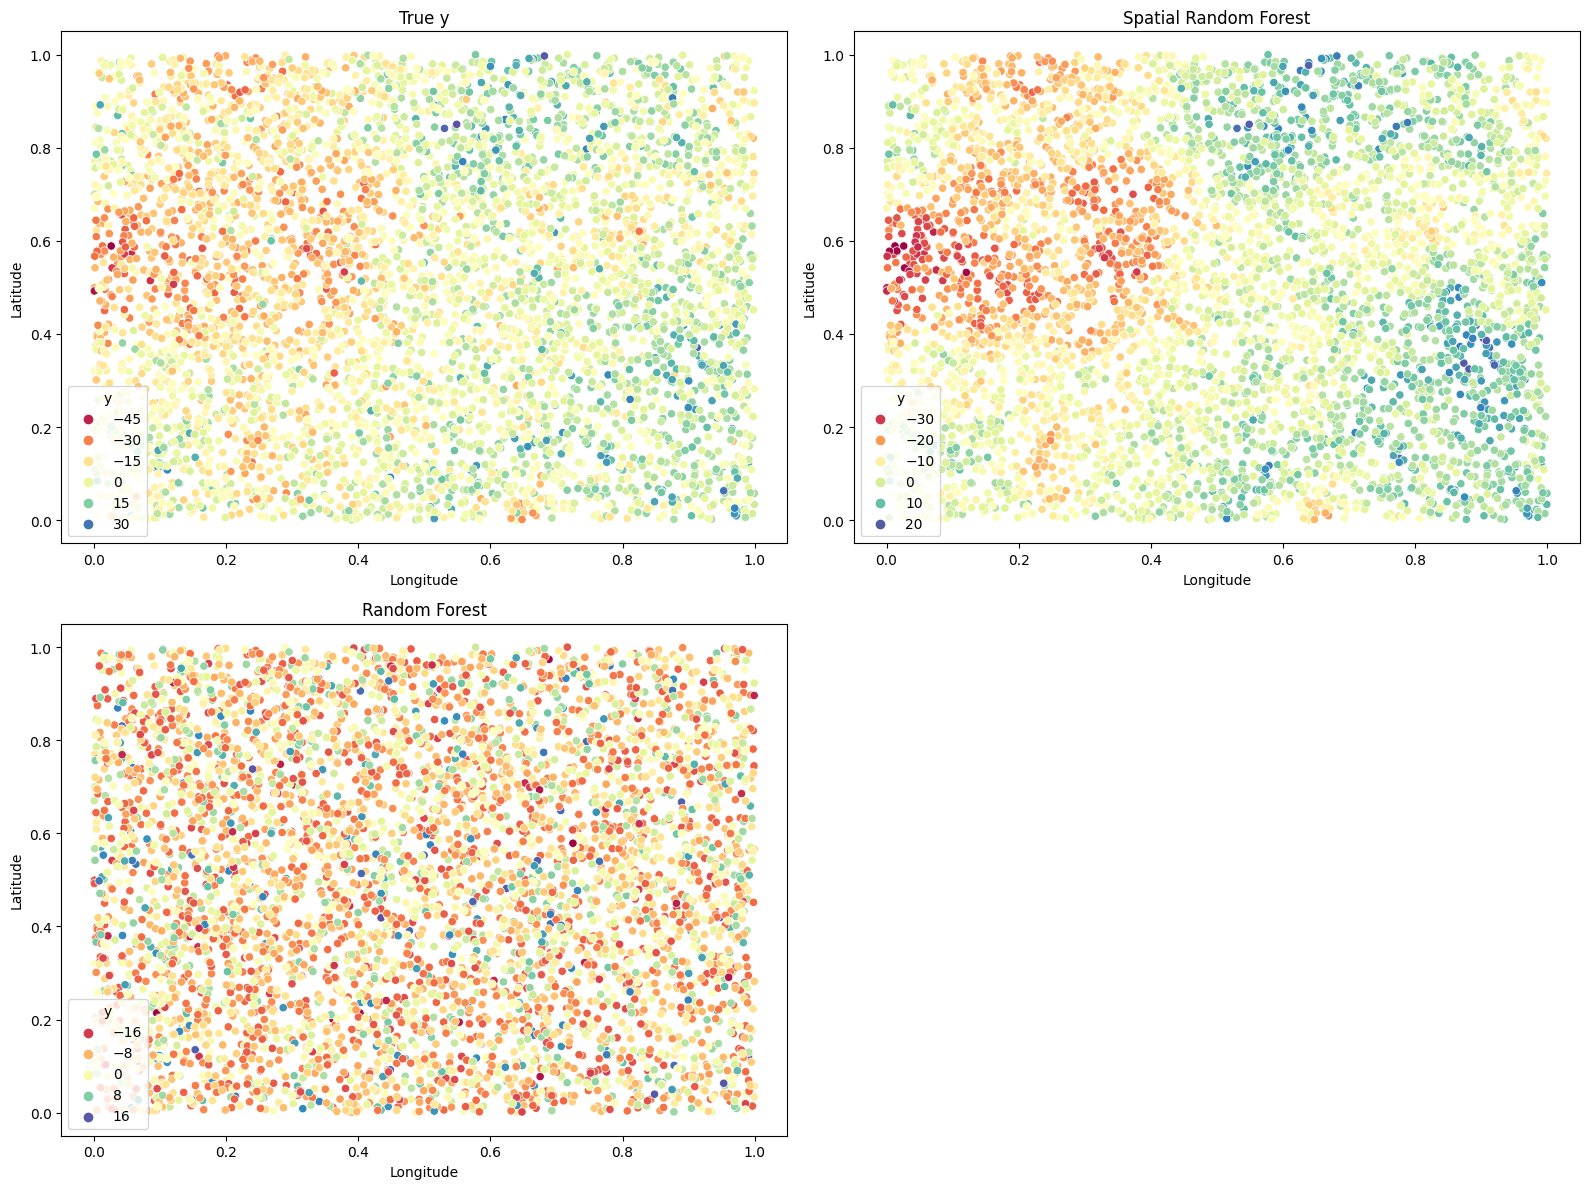

In [11]:
# Define the figure and subplots
plt.figure(figsize=(16, 12))

# Plot 1: True y
plt.subplot(2, 2, 1)
sns.scatterplot(data=testData, x=testLocs[:,0], y=testLocs[:,1], hue='y', palette='Spectral')
plt.title('True y')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(False)
plt.legend(title='y')

# Plot 2: Spatial Random Forest
plt.subplot(2, 2, 2)
sns.scatterplot(data=testData, x=testLocs[:,0], y=testLocs[:,1], hue=y_pred_spatial, palette='Spectral')
plt.title('Spatial Random Forest')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(False)
plt.legend(title='y')

# Plot 3: Random Forest
plt.subplot(2, 2, 3)
sns.scatterplot(data=testData, x=testLocs[:,0], y=testLocs[:,1], hue=y_pred, palette='Spectral')
plt.title('Random Forest')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(False)
plt.legend(title='y')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Variable Importance 

It can also be shown that the variable importance plots are practically the same if you want to find some interpretation in your random forest. 

In [9]:
spatial_importances = rf_spatial_fit.feature_importances_
importances = rf_fit.feature_importances_
indices = np.argsort(importances)[::-1]
spatial_indices = np.argsort(spatial_importances)[::-1]

plt.figure(figsize=(12, 8))

# Plot 1: Spatial Feature Importances
plt.subplot(2, 2, 1)
plt.title("Spatial Feature Importances")
plt.barh(range(len(spatial_importances)), spatial_importances[spatial_indices], align="center")
plt.yticks(range(len(spatial_importances)), spatial_indices)
plt.xlim([0, max(spatial_importances)])
plt.gca().invert_yaxis()  # Invert the y-axis
plt.xlabel("Importance")
plt.ylabel("Feature Index")

# Plot 2: Feature Importances
plt.subplot(2, 2, 2)
plt.title("Feature Importances")
plt.barh(range(len(importances)), importances[indices], align="center")
plt.yticks(range(len(importances)), indices)
plt.xlim([0, max(importances)])
plt.gca().invert_yaxis()  # Invert the y-axis
plt.xlabel("Importance")
plt.ylabel("Feature Index")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


NameError: name 'rf_spatial_fit' is not defined